In [1]:
%env GOOGLE_CLOUD_PROJECT=latent-state-learning

env: GOOGLE_CLOUD_PROJECT=latent-state-learning


In [2]:
from pprint import pprint
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import firebase_admin
from firebase_admin import firestore

app = firebase_admin.initialize_app()
db = firestore.client()

/home/insane/.pyenv/versions/3.12.4/lib/python3.12/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [12]:
# Fetch all the experiments
def get_new_docs_stream():
    return db.collection("experiments").stream()

experiments_raw = []
for doc in get_new_docs_stream():
    trials = []
    for i, trial in enumerate(doc.to_dict()['trials']):
        trials.append(trial)
    experiments_raw.append({
        'experiment_id': doc.id,
        'trials': trials,
    })
        
print(f'Total number of experiments: {len(experiments_raw)}')
pprint(experiments_raw)

Total number of experiments: 7
[{'experiment_id': 'AXK5VHOm4Z68h3cxX7Mb',
  'trials': [{'failed_audio': {},
              'failed_images': {},
              'failed_video': {},
              'internal_node_id': '0.0-0.0',
              'success': True,
              'time_elapsed': 334,
              'timeout': False,
              'trial_index': 0,
              'trial_type': 'preload'},
             {'internal_node_id': '0.0-1.0',
              'response': ' ',
              'rt': 4865,
              'stimulus': '<h1>Welcome to the psychiatric '
                          'experiment!</h1><p>Press any key to continue.</p>',
              'time_elapsed': 5200,
              'trial_index': 1,
              'trial_type': 'html-keyboard-response'},
             {'internal_node_id': '0.0-2.0',
              'rt': 9814,
              'time_elapsed': 15016,
              'trial_index': 2,
              'trial_type': 'instructions',
              'view_history': {'0': {'page_index': 0, 'viewi

In [13]:
# Preprocess the experiments
experiments = []
for experiment in experiments_raw:
    trials = []
    for trial in experiment['trials']:
        if trial['trial_type'] == 'dragndrop' and 'tutorial' not in trial:
            drag_data = trial['drag_data'] # { "0": { "0": { "x": 0, "y": 0, "t": 0 }, "1": { "x": 0, "y": 0, "t": 0 } } }
            converted_drag_data = []
            for key in drag_data:
                converted_drag_data.append(sorted([drag_data[key][str(i)] for i in range(len(drag_data[key]))], key=lambda x: x['time']))
            
            webgazer_data = trial['webgazer_data']
            webgazer_data = sorted([webgazer_data[key] for key in webgazer_data], key=lambda x: x['t'])
            trials.append({
                **trial,
                'drag_data': converted_drag_data,
                'webgazer_data': webgazer_data,
            })
        elif trial['trial_type'] == 'html-button-response' and 'tutorial' not in trial and 'webgazer_data' in trial:
            webgazer_data = trial['webgazer_data']
            webgazer_data = [webgazer_data[key] for key in webgazer_data]
            trials.append({
                **trial,
                'webgazer_data': webgazer_data,
            })
    experiments.append({
        'experiment_id': experiment['experiment_id'],
        'trials': trials,
    })
    
pprint(experiments)

[{'experiment_id': 'AXK5VHOm4Z68h3cxX7Mb', 'trials': []},
 {'experiment_id': 'F0c6XKozJBmxoYGA7tEB', 'trials': []},
 {'experiment_id': 'Mj35pFCJQARRQO5sLmZs', 'trials': []},
 {'experiment_id': 'RQPdnimBc9IbJeasNHLc', 'trials': []},
 {'experiment_id': 'ZypnRMRshdplmeb1ySHi',
  'trials': [{'estimated_state': 'Wyvern',
              'internal_node_id': '0.0-13.0-1.0',
              'new_state': True,
              'response': 1,
              'rt': 1233,
              'stimulus': '<img src="images/stimulus/animal_4.png" width="50%" '
                          '/>',
              'time_elapsed': 59415,
              'trial_index': 15,
              'trial_type': 'html-button-response',
              'webgazer_data': [{'t': 4, 'x': 820, 'y': 456},
                                {'t': 637, 'x': 1039, 'y': 662},
                                {'t': 781, 'x': 1078, 'y': 789},
                                {'t': 116, 'x': 839, 'y': 481},
                                {'t': 461, 'x': 997, 

In [22]:
# get all dragndrop trials drag_data of experiment i
EXPERIMENT_I  = 7
drag_data = []
for trial in experiments[EXPERIMENT_I]['trials']:
    if trial['trial_type'] == 'dragndrop':
        drag_data.append(trial['drag_data'])

# visualize drag_data
# drag_data_i format = [ [ { 'time': t, 'x': x, 'y': y } ] ]
# use the same color for first drag, and different color for the rest
plt.figure()
for drag_data_i in drag_data:
    for j, drag_data_j in enumerate(drag_data_i):
        if j == 0:
            color = 'r'
        else:
            color = 'b'
        x = [d['x'] for d in drag_data_j]
        y = [d['y'] for d in drag_data_j]
        plt.plot(x, y, color)
plt.title('Drag Data')
plt.show()

IndexError: list index out of range

I0000 00:00:1720815931.963833  239801 tcp_posix.cc:809] IOMGR endpoint shutdown


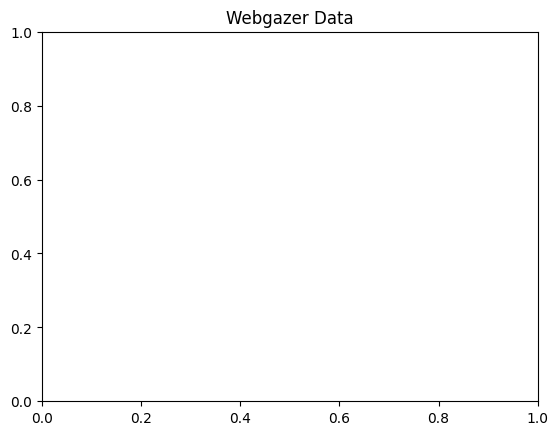

In [15]:
# do the same for webgazer_data
webgazer_data = []
for trial in experiments[EXPERIMENT_I]['trials']:
    if trial['trial_type'] == 'html-button-response':
        webgazer_data.append(trial['webgazer_data'])
        
# visualize webgazer_data
# webgazer_data_i format = [ { 't': t, 'x': x, 'y': y } ]
plt.figure()
for webgazer_data_i in webgazer_data:
    x = [d['x'] for d in webgazer_data_i]
    y = [d['y'] for d in webgazer_data_i]
    plt.plot(x, y)
plt.title('Webgazer Data')
plt.show()

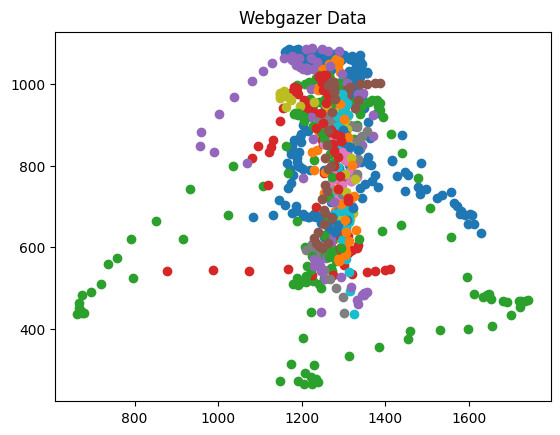

I0000 00:00:1720813941.962878  239729 tcp_posix.cc:809] IOMGR endpoint shutdown


In [9]:
# do the same for webgazer_data
webgazer_data = []
for trial in experiments[EXPERIMENT_I]['trials']:
    if trial['trial_type'] == 'html-button-response':
        webgazer_data.append(trial['webgazer_data'])
        
# visualize webgazer_data with scatter plot
# webgazer_data_i format = [ { 't': t, 'x': x, 'y': y } ]
plt.figure()
for webgazer_data_i in webgazer_data:
    x = [d['x'] for d in webgazer_data_i]
    y = [d['y'] for d in webgazer_data_i]
    plt.scatter(x, y)
plt.title('Webgazer Data')
plt.show()